In [1]:
from chinese_checkers.game import ChineseCheckersGame
from chinese_checkers.simulation import SimulationCatalog, GameSimulation, SimulationMetadata
from chinese_checkers.geometry import Printer

from typing import List

import pandas as pd
from tqdm import tqdm
from collections import Counter

In [5]:
# filter to only 2 player games on a size 4 board
catalog = SimulationCatalog()
metadata_list: List[SimulationMetadata] = [
    m
    for m in catalog.list_available_metadata()
    if m.player_count == 2 and m.board_size == 4
    # and m.name=="bootstrap-0d01-vs-dql-v004"
]

for meta in metadata_list:
    print(meta)

SimulationMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='0', name='bootstrap-simulation', version='v0.0.1')
SimulationMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='3', name='bootstrap-simulation', version='v0.0.1')
SimulationMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='0', name='bad-player-3-bootstrap-simulation', version='v0.0.1')
SimulationMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='3', name='bad-player-3-bootstrap-simulation', version='v0.0.1')
SimulationMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='None', name='bad-player-3-bootstrap-simulation', version='v0.0.1')
SimulationMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='0', name='bootstrap-simulation-p0d15', version='v0.0.1')
SimulationMetadata(player_count=2, board_size=4, max_game_length=1000, winning_player='3', name='bootstrap-simulation-p0d15'

In [6]:
simulations: List[GameSimulation] = []

with tqdm(metadata_list, desc="Loading Simulations") as progress_bar:
    for metadata in progress_bar:
        simulations += list(catalog.load_simulations_by_metadata(metadata))
        progress_bar.set_postfix({"Simulation Count": len(simulations)})

print(f"All {len(simulations)} simulations loaded.")

Loading Simulations: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it, Simulation Count=22275]

All 22275 simulations loaded.


In [7]:
# compute the summary statistics for the simulations
data = []
for sim in simulations:
    metadata: SimulationMetadata = sim.metadata
    data.append({
        "name": metadata.name,
        "version": metadata.version,
        "winning_player": metadata.winning_player,
        "game_length": len(sim.data.historical_moves)
    })

simulations_df = pd.DataFrame(data)

summary_df = simulations_df.groupby(["name", "version", "winning_player"]).agg(
    game_count=("winning_player", "size"),
    avg_game_length=("game_length", "mean"),
    min_game_length=("game_length", "min"),
    max_game_length=("game_length", "max"),
).reset_index()

metadata_summary_df = simulations_df.groupby(["name", "version"]).agg(
    total_games=("winning_player", "size"),
    winning_player_counts=("winning_player", lambda x: Counter(x))
).reset_index()

full_summary_df = pd.merge(summary_df, metadata_summary_df, on=["name", "version"])
full_summary_df

,name,version,winning_player,game_count,avg_game_length,min_game_length,max_game_length,total_games,winning_player_counts
0,bad-player-3-bootstrap-simulation,v0.0.1,0,433,473.882217,159,999,473,"{'0': 433, '3': 36, 'None': 4}"
1,bad-player-3-bootstrap-simulation,v0.0.1,3,36,566.944444,292,842,473,"{'0': 433, '3': 36, 'None': 4}"
2,bad-player-3-bootstrap-simulation,v0.0.1,None,4,1000.000000,1000,1000,473,"{'0': 433, '3': 36, 'None': 4}"
3,bootstrap-0d01-vs-dql-v004,v0.0.1,3,7967,382.387348,182,500,7967,{'3': 7967}
4,bootstrap-simulation,v0.0.1,0,890,319.231461,115,515,1747,"{'0': 890, '3': 857}"
5,bootstrap-simulation,v0.0.1,3,857,317.682614,124,522,1747,"{'0': 890, '3': 857}"
6,bootstrap-simulation-p0d15,v0.0.1,0,1345,795.539777,165,999,2682,"{'0': 1345, '3': 1337}"
7,bootstrap-simulation-p0d15,v0.0.1,3,1337,789.645475,240,1000,2682,"{'0': 1345, '3': 1337}"
8,bootstrap-simulation-random-noise,v0.0.1,0,5,261.000000,237,279,4503,"{'3': 4498, '0': 5}"
9,bootstrap-simulation-random-noise,v0.0.1,3,4498,267.225878,122,300,4503,"{'3': 4498, '0': 5}"


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

all_moves = []
for sim in simulations:
    # if sim.metadata.name in ['bad-player-3-bootstrap-simulation']:
    all_moves.extend(sim.data.historical_moves)

move_counts = Counter(all_moves)

move_df = pd.DataFrame(list(move_counts.items()), columns=["move", "count"])

total_moves = len(all_moves)
unique_moves = move_df[move_df["count"] == 1].shape[0]
duplicate_moves = move_df[move_df["count"] > 1].shape[0]
max_duplicate_count = move_df["count"].max()
mean_duplicate_count = move_df[move_df["count"] > 1]["count"].mean()

summary_stats = {
    "total_moves": total_moves,
    "unique_moves": unique_moves,
    "duplicate_moves": duplicate_moves,
    "max_duplicate_count": max_duplicate_count,
    "mean_duplicate_count": mean_duplicate_count,
}
summary_df = pd.DataFrame([summary_stats])

print(summary_df)

plt.figure(figsize=(10, 6))
move_df[move_df["count"] > 1]["count"].plot(kind="hist", bins=200, edgecolor="black")
plt.title("Distribution of Duplicate Move Counts")
plt.xlabel("Duplicate Count")
plt.ylabel("Frequency")
plt.show()


In [7]:
move_df.sort_values(by='count', ascending=False)

,move,count
6,"Move(4, -4), Position(-1, 5)",1959
8,"Move(-4, 4), Position(3, 1)",1758
136,"Move(-4, 4), Position(0, -4)",1030
135,"Move(4, -4), Position(-4, 0)",1026
178,"Move(-1, 1), Position(3, 1)",886
...,...,...
2670,"Move(0, -8), Position(-3, 5)",1
2674,"Move(4, 0), Position(0, -1)",1
2675,"Move(0, 8), Position(-3, -3)",1
2676,"Move(1, 0), Position(6, -3)",1


In [8]:
move_df.sort_values(by='count', ascending=True)

,move,count
2689,"Move(2, -6), Position(-5, 3)",1
2669,"Move(0, 1), Position(6, -4)",1
2668,"Move(1, 0), Position(5, -4)",1
2666,"Move(2, 0), Position(2, -3)",1
2665,"Move(6, -4), Position(-3, 6)",1
...,...,...
178,"Move(-1, 1), Position(3, 1)",886
135,"Move(4, -4), Position(-4, 0)",1026
136,"Move(-4, 4), Position(0, -4)",1030
8,"Move(-4, 4), Position(3, 1)",1758


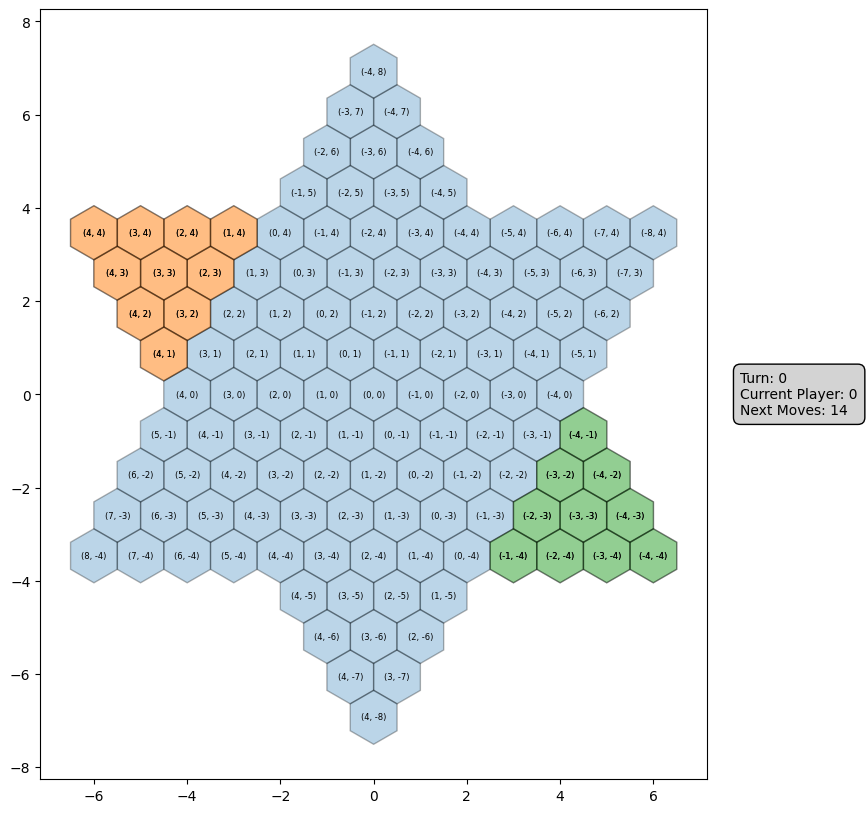

In [9]:
game = ChineseCheckersGame.start_game(2, 4)
game = ChineseCheckersGame(game.players, game.turn, game.board, Printer(show_coordinates=True))
game.print()